In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import itertools
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
from torch.utils.data import random_split
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

In [ ]:
torch.manual_seed (0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
class AllConv (nn.Module):

    def __init__(self, n_classes):
        super(AllConv, self).__init__()
        
        self.n_classes = n_classes

        self.ipdrop = nn.Dropout (0.2)
        self.dropout = nn.Dropout (0.5)
        
        self.conv_1 = torch.nn.Conv2d(in_channels=3,
                                      out_channels=96,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      padding=1) 
    
        self.conv_2 = torch.nn.Conv2d(in_channels=96,
                                      out_channels=96,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      padding=1)                             
        
        self.pool_1 = torch.nn.Conv2d(in_channels=96,
                                      out_channels=96,
                                      kernel_size=(3, 3),
                                      stride=(2, 2),
                                      padding=1)                  
                                    
        self.conv_4 = torch.nn.Conv2d(in_channels=96,
                                      out_channels=192,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      padding=1)      
        
                                    
        self.conv_5 = torch.nn.Conv2d(in_channels=192,
                                      out_channels=192,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      padding=1)       
                                 
        self.pool_2 = torch.nn.Conv2d(in_channels=192,
                                      out_channels=192,
                                      kernel_size=(3, 3),
                                      stride=(2, 2),
                                      padding=1)      
                                    
        self.conv_7 = torch.nn.Conv2d(in_channels=192,
                                      out_channels=192,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      padding=1)

        self.conv_8 = torch.nn.Conv2d(in_channels=192,
                                      out_channels=192,
                                      kernel_size=(1, 1),
                                      stride=(1, 1),
                                      padding=1)

        self.conv_9 = torch.nn.Conv2d(in_channels=192,
                                      out_channels=self.n_classes,
                                      kernel_size=(1, 1),
                                      stride=(1, 1),
                                      padding=1)
        
    def forward(self, x):

        out = self.conv_1(x)
        out = F.elu(out)
        out = self.ipdrop (out)

        out = self.conv_2(out)
        out = F.elu(out)

        out = self.pool_1(out)
        out = F.elu(out)

        out = self.dropout (out)

        out = self.conv_4(out)
        out = F.elu(out)
        
        out = self.conv_5(out)
        out = F.elu(out)
        
        out = self.pool_2(out)
        out = F.elu(out)

        out = self.dropout (out)
        
        out = self.conv_7(out)
        out = F.elu(out)

        out = self.conv_8(out)
        out = F.elu(out)

        out = self.conv_9(out)
        out = F.elu(out)
        
        logits = F.adaptive_avg_pool2d(out, 1)
        # drop width
        logits.squeeze_(-1)
        # drop height
        logits.squeeze_(-1)
        preds = torch.softmax(logits, dim=1)
        return logits, preds

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# train, valid = random_split (trainset, [len (trainset)*0.8, len (trainset)*0.2])

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 169001437/169001437 [00:03<00:00, 45646776.32it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
loss_function = nn.CrossEntropyLoss ()

learning_rate = 1e-3

model = AllConv(100)

model = model.to(device)

epochs = 50

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
scheduler = StepLR (optimizer, step_size=20, gamma=0.1) 

In [ ]:
def graph_plot(x, vy, ty, ax, colors=['b']):
  ax.plot(x, vy, 'b', label="Test")
  ax.plot(x, ty, 'r', label="Train")
  plt.legend()
  plt.grid()
  fig.canvas.draw()

In [ ]:
def train_one_epoch (model, optimizer, trainloader):
  loss = 0
  y_hat = []
  y_true = []

  for features, targets in trainloader:

    features = features.to(device)
    targets = targets.to(device)

    logits, probas = model(features)
    cost = F.cross_entropy(logits, targets)

    loss += cost.item ()
    optimizer.zero_grad()
    
    _, predicted_labels = torch.max(probas, 1)
    
    y_hat.append (predicted_labels.tolist ())
    y_true.append (targets.tolist ())
    cost.backward()
    
    ### UPDATE MODEL PARAMETERS
    optimizer.step()
    i=0
    epsilon = 5
    with torch.no_grad ():
      for name,params in model.named_parameters():
        if 'conv_1.weight' or 'conv_1.bias' in name:
          continue
        newparams=params.detach().clone()
        params.copy_(torch.where(newparams < 0, torch.exp(newparams - epsilon), newparams))

  y_hat = list (itertools.chain (*y_hat))
  y_true = list (itertools.chain (*y_true))
  accuracy = accuracy_score (y_hat, y_true)

  loss = loss/len (trainloader)

  return loss, accuracy

In [ ]:
def test_one_epoch (model, testloader):
  y_hat = []
  y_true = []

  loss = 0

  for features, targets in testloader:

    features = features.to(device)
    targets = targets.to(device)

    logits, probas = model(features)
    
    _, predicted_labels = torch.max(probas, 1)
    
    cost = F.cross_entropy(logits, targets)
    loss += cost.item ()

    y_hat.append (predicted_labels.tolist ())
    y_true.append (targets.tolist ())
  
  y_hat = list (itertools.chain (*y_hat))
  y_true = list (itertools.chain (*y_true))
  accuracy = accuracy_score (y_hat, y_true)
  
  loss = loss/len (testloader)

  return loss, accuracy

In [ ]:
train_losses = []
train_accuracies = []

test_losses = []
test_accuracies = []

for epoch in tqdm (range (epochs)):
  model = model.train()
  loss, accuracy = train_one_epoch (model, optimizer, trainloader)
  train_losses.append (loss)
  train_accuracies.append (accuracy)
  scheduler.step ()

  with torch.no_grad ():
    model = model.eval ()
    loss, accuracy = test_one_epoch (model, testloader)
    test_losses.append (loss)
    test_accuracies.append (accuracy)

100%|██████████| 50/50 [19:57<00:00, 23.96s/it]


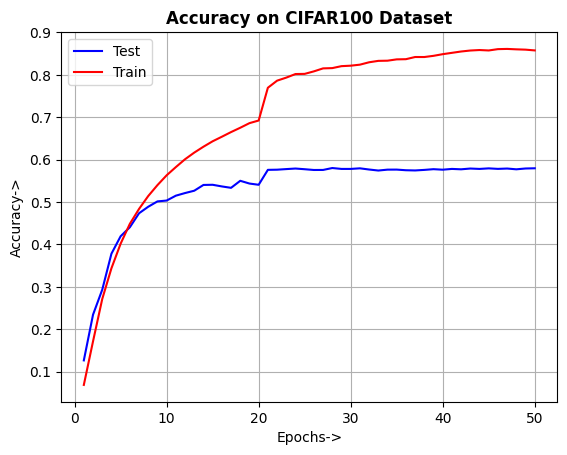

In [ ]:
fig, ax = plt.subplots(1,1)
ax.set_xlabel('Epochs->')  
ax.set_ylabel('Accuracy->')
ax.set_title('Accuracy on CIFAR100 Dataset', fontweight="bold")

x = list(range(1, epochs+1))

vy = test_accuracies
ty = train_accuracies

graph_plot(x, vy, ty, ax)

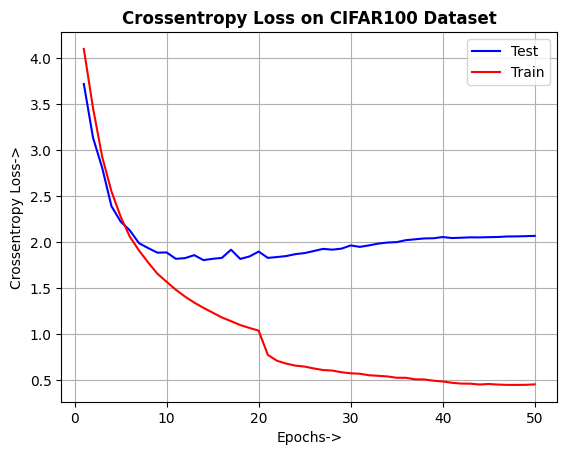

In [ ]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('Epochs->')  
ax.set_ylabel('Crossentropy Loss->')
ax.set_title('Crossentropy Loss on CIFAR100 Dataset', fontweight="bold")

x = list(range(1, epochs+1))

vy = test_losses
ty = train_losses

graph_plot(x, vy, ty, ax)

In [ ]:
print (train_losses [-1], test_losses [-1])

0.4517403187806649 2.0656496769265282


In [ ]:
for data in model.named_parameters ():
  print (data [0])

conv_1.weight
conv_1.bias
conv_2.weight
conv_2.bias
pool_1.weight
pool_1.bias
conv_4.weight
conv_4.bias
conv_5.weight
conv_5.bias
pool_2.weight
pool_2.bias
conv_7.weight
conv_7.bias
conv_8.weight
conv_8.bias
conv_9.weight
conv_9.bias


In [ ]:
print (train_accuracies [-1], test_accuracies [-1])

0.8575 0.5795


In [ ]:
print ("generalisation gap: ", train_accuracies [-1] - test_accuracies [-1])

generalisation gap:  0.278


In [ ]:
torch.save(model.state_dict(), 'ioc_allconv_cifar100.pt')